<a href="https://colab.research.google.com/github/mohammadathania/ALY6110/blob/main/Module4Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 199 kB 54.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=50f0224b328bd0073ca9af01558a60853c1a13ec5a81cf349291037dd528b405
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [4]:
spark = SparkSession.builder.master("local[2]").appName("California Housing").getOrCreate()

In [5]:
spark

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=California Housing>

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [27]:
df = spark.read.csv("housing.csv", inferSchema=True, header = True)


In [28]:
df.show(5)


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [29]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [36]:
df.select(['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'median_house_value']).describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|median_house_value|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|206855.81690891474|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403115|115395.61587441359|
|    min|            -124.35|            32.54|               1.0|               2.0|               1.0|           14999.0|
|    max|            -114.31|            41.95|              52.0|           39320.0|            6445.0|          500001.0|
+-------

In [31]:
df.na.drop()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string]

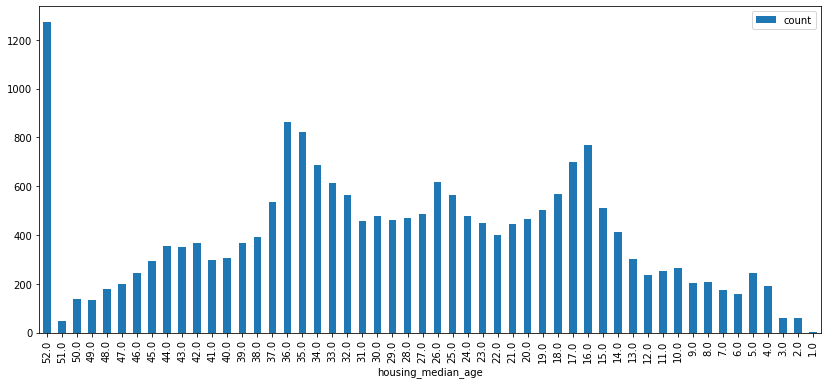

In [34]:
median_age = df.groupBy("housing_median_age").count().sort("housing_median_age", ascending=False)
median_age.toPandas().plot.bar(x='housing_median_age',figsize=(14, 6))


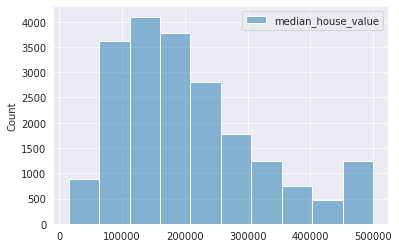

In [44]:
sns.histplot(df.select('median_house_value').toPandas(), bins = 10)

[(0.0, 500.0)]

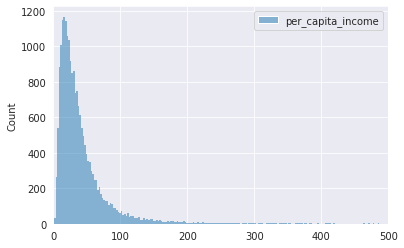

In [47]:
df = df.withColumn('per_capita_income', df['median_income']*10000/df['population'])
g = sns.histplot(df.select('per_capita_income').toPandas())
g.set(xlim = (0, 500))

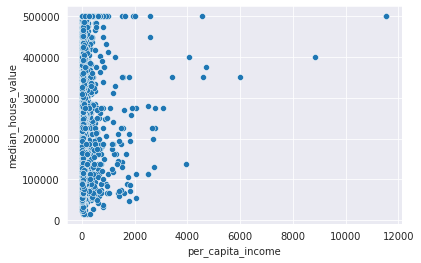

In [48]:
df_pandas = df.toPandas()
sns.scatterplot(x = df_pandas['per_capita_income'], y = df_pandas['median_house_value'])


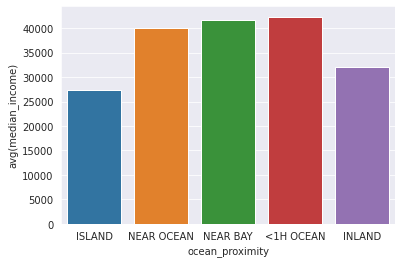

In [58]:
df_income = df.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_pandas_income = df_income.toPandas()
sns.barplot(x = df_pandas_income['ocean_proximity'], y = df_pandas_income['avg(median_income)']*10000)

In [60]:
#Label-encoding for the "ocean_proximity" column
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index") 
df = indexer.fit(df).transform(df)
df = df.drop('ocean_proximity')
df.select('ocean_proximity_index').show(3)

#Removing na values to ensure correlation method works properly
mean = df.select(F.mean('total_bedrooms')).collect()[0][0]
df = df.na.fill({'total_bedrooms': mean})

#Checking if na values exist in 'total_bedrooms' columns
df.filter(col('total_bedrooms').isNull()).show()

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 3 rows

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------+---------------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------+---------------------+



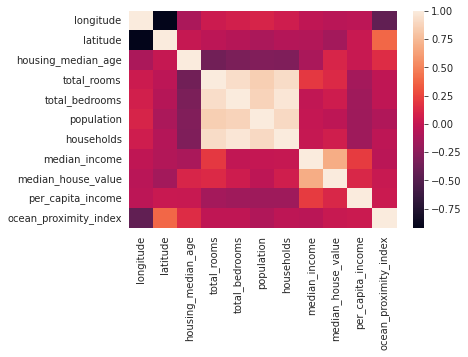

In [63]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df.columns, index = df.columns)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr)

In [65]:
df_model = df.select(['housing_median_age','total_rooms', 'median_income','median_house_value'])
df_model.show(3)

+------------------+-----------+-------------+------------------+
|housing_median_age|total_rooms|median_income|median_house_value|
+------------------+-----------+-------------+------------------+
|              41.0|      880.0|       8.3252|          452600.0|
|              21.0|     7099.0|       8.3014|          358500.0|
|              52.0|     1467.0|       7.2574|          352100.0|
+------------------+-----------+-------------+------------------+
only showing top 3 rows



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+----------------------------+----------------------------+
|skewness(housing_median_age)|kurtosis(housing_median_age)|
+----------------------------+----------------------------+
|        0.060326253016608676|         -0.8007255995445028|
+----------------------------+----------------------------+



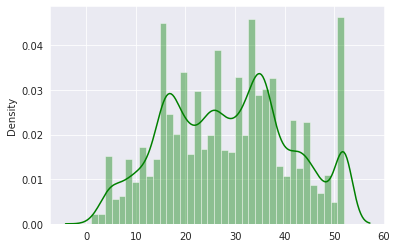

In [73]:
#Checking normal distribution of selected fetures
#housing_median_age

sns.distplot(df.select('housing_median_age').toPandas(), color="green")
df.select(F.skewness('housing_median_age'), F.kurtosis('housing_median_age')).show()

#the housing_median_age is normally distributed

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+---------------------+---------------------+
|skewness(total_rooms)|kurtosis(total_rooms)|
+---------------------+---------------------+
|    4.147042038773302|    32.62273207294906|
+---------------------+---------------------+



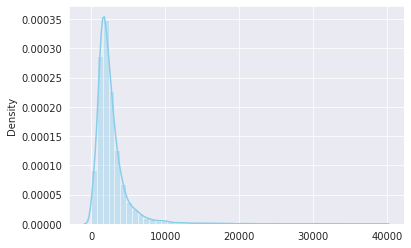

In [68]:
#Checking normal distribution of selected fetures
#total_rooms

sns.distplot(df.select('total_rooms').toPandas(), color="skyblue")
df.select(F.skewness('total_rooms'), F.kurtosis('total_rooms')).show()

#the total_rooms is not normally distributed

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+----------------------------------+----------------------------------+
|skewness(total_rooms_logtransform)|kurtosis(total_rooms_logtransform)|
+----------------------------------+----------------------------------+
|               -1.0972584854175316|                  5.25204961078785|
+----------------------------------+----------------------------------+



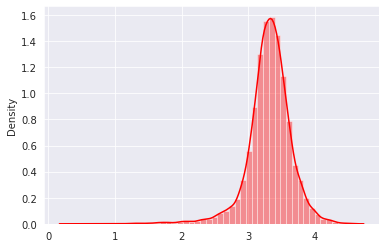

In [69]:
#Using lograthimic scale to normalize the data

df_model = df_model.withColumn("total_rooms_logtransform", F.log10(col("total_rooms")))

sns.distplot(df_model.select('total_rooms_logtransform').toPandas(), color="red")
df_model.select(F.skewness('total_rooms_logtransform'), F.kurtosis('total_rooms_logtransform')).show()

#The distribution is now lograthmic distributed

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+-----------------------+-----------------------+
|skewness(median_income)|kurtosis(median_income)|
+-----------------------+-----------------------+
|     1.6465370299001063|      4.951033760409806|
+-----------------------+-----------------------+



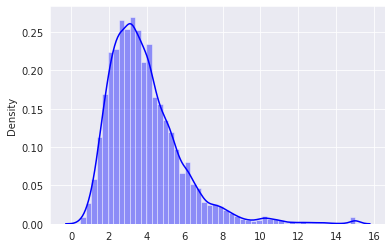

In [70]:
#Checking normal distribution of selected fetures
#median_income

sns.distplot(df.select('median_income').toPandas(), color="blue")
df.select(F.skewness('median_income'), F.kurtosis('median_income')).show()

#the median_income is normally distributed

In [75]:
#Assembling features
feature_assembly = VectorAssembler(inputCols = ['housing_median_age','total_rooms_logtransform', 'median_income'], outputCol = 'features')
output = feature_assembly.transform(df_model)
output.show(3)

+------------------+-----------+-------------+------------------+------------------------+--------------------+
|housing_median_age|total_rooms|median_income|median_house_value|total_rooms_logtransform|            features|
+------------------+-----------+-------------+------------------+------------------------+--------------------+
|              41.0|      880.0|       8.3252|          452600.0|      2.9444826721501687|[41.0,2.944482672...|
|              21.0|     7099.0|       8.3014|          358500.0|      3.8511971761741606|[21.0,3.851197176...|
|              52.0|     1467.0|       7.2574|          352100.0|       3.166430113843283|[52.0,3.166430113...|
+------------------+-----------+-------------+------------------+------------------------+--------------------+
only showing top 3 rows



In [76]:
#Normalizing the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+------------------+-----------+-------------+------------------+------------------------+--------------------+--------------------+
|housing_median_age|total_rooms|median_income|median_house_value|total_rooms_logtransform|            features|      scaledFeatures|
+------------------+-----------+-------------+------------------+------------------------+--------------------+--------------------+
|              41.0|      880.0|       8.3252|          452600.0|      2.9444826721501687|[41.0,2.944482672...|[3.25770230160830...|
|              21.0|     7099.0|       8.3014|          358500.0|      3.8511971761741606|[21.0,3.851197176...|[1.66857922765303...|
|              52.0|     1467.0|       7.2574|          352100.0|       3.166430113843283|[52.0,3.166430113...|[4.13171999228370...|
+------------------+-----------+-------------+------------------+------------------------+--------------------+--------------------+
only showing top 3 rows



In [77]:
#Selecting input and output column from output
df_model_final = scaledOutput.select(['median_house_value', 'scaledFeatures'])
df_model_final.show(3)

+------------------+--------------------+
|median_house_value|      scaledFeatures|
+------------------+--------------------+
|          452600.0|[3.25770230160830...|
|          358500.0|[1.66857922765303...|
|          352100.0|[4.13171999228370...|
+------------------+--------------------+
only showing top 3 rows



In [78]:
#fit PCA model
n_components = 2
pca = PCA(
    k= n_components,
    inputCol = 'scaledFeatures',
    outputCol = 'pcaFeatures'
).fit(scaledOutput)

df_pca = pca.transform(scaledOutput)
print("explained variance ratio", pca.explainedVariance.toArray())
df_pca.show(10)

explained variance ratio [0.47893299 0.29768313]
+------------------+-----------+-------------+------------------+------------------------+--------------------+--------------------+--------------------+
|housing_median_age|total_rooms|median_income|median_house_value|total_rooms_logtransform|            features|      scaledFeatures|         pcaFeatures|
+------------------+-----------+-------------+------------------+------------------------+--------------------+--------------------+--------------------+
|              41.0|      880.0|       8.3252|          452600.0|      2.9444826721501687|[41.0,2.944482672...|[3.25770230160830...|[5.98362628694972...|
|              21.0|     7099.0|       8.3014|          358500.0|      3.8511971761741606|[21.0,3.851197176...|[1.66857922765303...|[8.73448504490880...|
|              52.0|     1467.0|       7.2574|          352100.0|       3.166430113843283|[52.0,3.166430113...|[4.13171999228370...|[5.64093287035072...|
|              52.0|     12

In [79]:
#collect data in Numpy Array
x_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
x_pca = np.array(x_pca)
x_pca

array([[ 5.98362629,  4.01538514],
       [ 8.73448504,  2.78591626],
       [ 5.64093287,  3.87645718],
       ...,
       [ 6.30043523, -0.09961197],
       [ 6.12789141,  0.05367912],
       [ 6.70111504,  0.12621228]])

In [80]:
#convert array to dataframe 
df_pca = pd.DataFrame(x_pca, columns= ['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,5.983626,4.015385
1,8.734485,2.785916
2,5.640933,3.876457
3,5.120140,3.182190
4,4.888262,2.329183


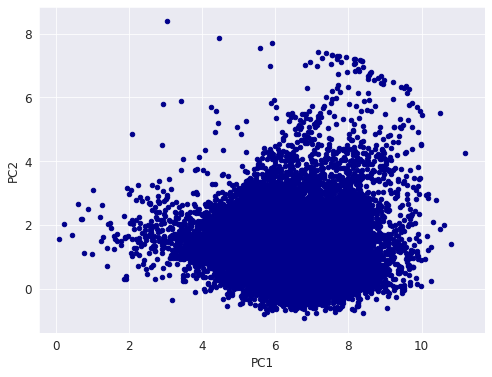

In [82]:
#plot two principal components 
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size']= 12
ax1 = df_pca.plot.scatter(x='PC1', y='PC2', c='DarkBlue')

In [84]:
from pyspark.ml.regression import LinearRegression 

#test train split
df_train, df_test = df_model_final.randomSplit([0.75, 0.25])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'median_house_value')
regressor = regressor.fit(df_train)

In [87]:
#evaluate the model
pred = regressor.evaluate(df_test)
#predict the model
pred.predictions.show()

+------------------+--------------------+------------------+
|median_house_value|      scaledFeatures|        prediction|
+------------------+--------------------+------------------+
|           14999.0|[1.50966692025750...| 99757.29042301139|
|           32500.0|[4.13171999228370...|159300.15706567885|
|           32900.0|[1.11238615176869...| 58667.11034681198|
|           33200.0|[1.66857922765303...| 86773.64592744356|
|           34200.0|[2.46314076463067...| 79046.74950548632|
|           35000.0|[3.09878999421277...| 180298.7715859695|
|           36700.0|[2.46314076463067...| 83341.16696912063|
|           37500.0|[0.79456153697763...| 63301.64104877987|
|           37500.0|[2.86042153311948...| 157306.4989697428|
|           38800.0|[1.58912307395527...|102485.23967339039|
|           40000.0|[0.95347384437316...|107739.48242480592|
|           40400.0|[2.78096537942172...| 215842.4331181377|
|           41400.0|[1.82749153504856...| 98617.32756557087|
|           41500.0|[2.5

In [88]:
pred_results = regressor.evaluate(df_train)
print("The MSE for the model is: %2f"% pred_results.meanSquaredError)
print("The RMSE for the model is: %2f"% pred_results.rootMeanSquaredError)
print("The MAE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The R2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 6522437045.408183
The RMSE for the model is: 80761.606258
The MAE for the model is: 60166.319125
The R2 for the model is: 0.514097


In [89]:
pred_results = regressor.evaluate(df_test)
print("The MSE for the model is: %2f"% pred_results.meanSquaredError)
print("The RMSE for the model is: %2f"% pred_results.rootMeanSquaredError)
print("The MAE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The R2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 6256040982.232998
The RMSE for the model is: 79095.138803
The MAE for the model is: 59740.631155
The R2 for the model is: 0.518052
